In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

seed = 3

# Train an MLP on lineup data consisting of player stat profiles from previous year

In [23]:
df = pd.read_csv('datasets/4man_lineups_with_player_stat_profiles.csv', index_col=0)
df.shape
df.head()

(3368, 351)

,diff_pts,year,mp,1,2,3,4,5,6,7,...,342,343,344,345,346,347,348,349,350,351
lineup,,,,,,,,,,,,,,,,,,,,,
A. Afflalo | C. Anthony | C. Billups | K. Martin DEN 2010,7.2,2010,598.850000,23,74,1234,8.9,0.548,0.357,0.237,...,104.0,2.0,4.8,18.5,2.3,2.5,9.5,81,234,2
A. Afflalo | C. Anthony | C. Billups | K. Martin DEN 2011,7.8,2011,351.216667,24,82,2221,10.9,0.576,0.426,0.168,...,101.0,3.6,4.7,17.0,1.8,2.3,13.9,81,234,2
A. Afflalo | C. Anthony | C. Billups | N. Hilário DEN 2010,4.8,2010,1073.500000,23,74,1234,8.9,0.548,0.357,0.237,...,120.0,3.7,5.6,22.8,1.9,3.0,12.1,73,250,0
A. Afflalo | C. Anthony | C. Billups | N. Hilário DEN 2011,4.0,2011,807.683333,24,82,2221,10.9,0.576,0.426,0.168,...,124.0,3.1,5.2,20.9,2.1,2.3,11.5,73,250,7
A. Afflalo | C. Anthony | J. Calderón | R. Lopez NYK 2016,-3.8,2016,953.283333,29,78,2502,10.7,0.533,0.377,0.224,...,117.0,5.9,3.8,17.6,0.5,2.3,12.3,84,281,7


### Define Train, Test, split

In [44]:
X = df.drop(['year', 'diff_pts'], axis=1)
y = df[['diff_pts']]


X_train = df[df['year'] < 2017].drop(['year', 'diff_pts'], axis=1)
y_train = df[df['year'] < 2017][['diff_pts']]

X_test = df[df['year'] >= 2017].drop(['year', 'diff_pts'], axis=1)
y_test = df[df['year'] >= 2017][['diff_pts']]

X_train.shape, y_train.shape
X_test.shape, y_test.shape

((2834, 349), (2834, 1))

((534, 349), (534, 1))

In [27]:
def build_MLP(sizes, activation, output_activation=nn.Identity):
    layers = []
    for i in range(len(sizes)-1):
        active_fn = activation if i < len(sizes) - 2 else output_activation
        layers += [nn.Linear(in_features=sizes[i], out_features=sizes[i+1]), active_fn()]
    mlp = nn.Sequential(*layers)
    return mlp

In [29]:
def torch_train_test_split(X, y, test_size, random_state=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    datasets = []
    for dataset in [X_train, X_test, y_train, y_test]:
        datasets.append(torch.tensor(dataset.to_numpy(), dtype=torch.float32))        
    return datasets

## Define an mlp

Wall time: 16min 2s


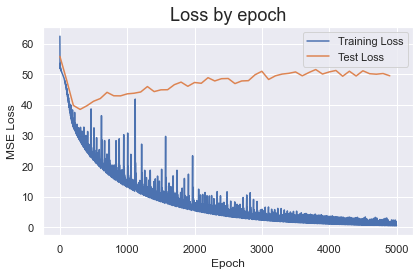

In [85]:
%%time

in_dim = 349
hidden_sizes = [349, 512, 512, 512, 256, 128]
out_dim = 1
sizes = [in_dim] + hidden_sizes + [out_dim]
activation = nn.ReLU
mlp = build_MLP(sizes, activation)

mlp_learning_rate = 0.0001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=mlp_learning_rate)

epochs = 5_000

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch_train_test_split(X, y, 0.2, seed)

training_losses = []
test_losses = {}



for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = mlp(X_train_tensor)
    train_loss = loss_fn(y_hat, y_train_tensor)
    training_losses.append(train_loss.item())    
    train_loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        y_hat_test = mlp(X_test_tensor)
        test_loss = loss_fn(y_hat_test, y_test_tensor)
        test_losses[epoch] = test_loss.item()

### Plot training results:
fig, ax = plt.subplots()
ax.set_title('Loss by epoch', fontsize=18)
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Epoch')

sns.lineplot(x=[i for i in range(epochs)], y=training_losses, label='Training Loss', ax=ax)
plt.tight_layout()

sns.lineplot(x=test_losses.keys(), y=[test_losses[epoch] for epoch in test_losses.keys()], label='Test Loss', ax=ax)
plt.tight_layout()

plt.legend();

fig.savefig('mlp_lineup_player_stats_5k.png', bbox_inches='tight')